In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [48]:
train_transaction = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
train_identity = pd.read_csv('ieee-fraud-detection/train_identity.csv')
test_transaction = pd.read_csv('ieee-fraud-detection/test_transaction.csv')
test_identity = pd.read_csv('ieee-fraud-detection/test_identity.csv')

## Transaction Table 
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

## Identity Table
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id_12 - id_38

In [26]:
list(train_transaction.columns)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

In [53]:
user_id = train_transaction[['TransactionID','card1','card2','card3','card4','card5','card6','P_emaildomain']].groupby(['card1','card2','card3','card4','card5','card6','P_emaildomain']).count().sort_values(by='TransactionID', ascending=False).reset_index().reset_index().rename(columns={'index':'UserID'})
user_id.drop('TransactionID',axis = 1, inplace=True)

In [54]:
user_id

UserID  card1  card2  card3       card4  card5  card6  P_emaildomain
0           0   9500  321.0  150.0        visa  226.0  debit      gmail.com
1           1   7919  194.0  150.0  mastercard  166.0  debit      gmail.com
2           2  15885  545.0  185.0        visa  138.0  debit    hotmail.com
3           3  17188  321.0  150.0        visa  226.0  debit      gmail.com
4           4  15885  545.0  185.0        visa  138.0  debit      gmail.com
...       ...    ...    ...    ...         ...    ...    ...            ...
38318   38318   9280  517.0  150.0  mastercard  224.0  debit      yahoo.com
38319   38319   9280  517.0  150.0  mastercard  224.0  debit    hotmail.com
38320   38320   9277  206.0  150.0  mastercard  229.0  debit      yahoo.com
38321   38321   9277  206.0  150.0  mastercard  229.0  debit          q.com
38322   38322  18396  111.0  150.0        visa  226.0  debit  anonymous.com

[38323 rows x 8 columns]

In [55]:
train_transaction = pd.merge(train_transaction, user_id, how="inner", on=['card1','card2','card3','card4','card5','card6','P_emaildomain'])

In [57]:
product_id = train_transaction[['TransactionID','addr1','addr2','ProductCD', 'R_emaildomain']].groupby(['addr1','addr2','ProductCD', 'R_emaildomain']).count().sort_values(by='TransactionID', ascending=False).reset_index()

In [58]:
product_id['ProductID'] = np.array([i+len(user_id) for i in range(len(product_id))])
product_id.drop('TransactionID',axis = 1, inplace=True)

In [59]:
product_id

addr1  addr2 ProductCD  R_emaildomain  ProductID
0     299.0   87.0         R      gmail.com      38323
1     299.0   87.0         H      gmail.com      38324
2     299.0   87.0         R  anonymous.com      38325
3     325.0   87.0         H      gmail.com      38326
4     204.0   87.0         R      gmail.com      38327
...     ...    ...       ...            ...        ...
2312  433.0   87.0         R       live.com      40635
2313  433.0   87.0         R        mac.com      40636
2314  299.0   87.0         R     cfl.rr.com      40637
2315  433.0   87.0         R        msn.com      40638
2316  203.0   87.0         H        aol.com      40639

[2317 rows x 5 columns]

In [60]:
train_transaction = pd.merge(train_transaction, product_id, how="inner", on=['addr1','addr2','ProductCD', 'R_emaildomain'])

In [69]:
train_transaction

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0            2990906        1         160261           150.0         R   2755   
1            2990909        1         160298           150.0         R   2755   
2            3348703        0        8972070            75.0         R  18132   
3            3093880        0        2130818           100.0         R  11401   
4            3026696        0         962295           500.0         R   1724   
...              ...      ...            ...             ...       ...    ...   
62290        3556489        0       15107691            40.0         H  17262   
62291        3563234        0       15304170           150.0         H  13925   
62292        3563235        0       15304233           150.0         H  13925   
62293        3564357        0       15360596            75.0         H  15066   
62294        3565712        0       15420237            75.0         R  14873   

       card2  card3       card4  card5  ...   V332   V333  V334  V335  V336  \
0      404.0  150.0  mastercard  102.0  ...    0.0    0.0   0.0   0.0   0.0   
1      404.0  150.0  mastercard  102.0  ...    0.0    0.0   0.0   0.0   0.0   
2      567.0  150.0  mastercard  117.0  ...    0.0    0.0   0.0   0.0   0.0   
3      543.0  150.0  mastercard  117.0  ...    0.0    0.0   0.0   0.0   0.0   
4      583.0  150.0        visa  226.0  ...    0.0    0.0   0.0   0.0   0.0   
...      ...    ...         ...    ...  ...    ...    ...   ...   ...   ...   
62290  578.0  150.0  mastercard  166.0  ...    0.0    0.0   0.0   0.0   0.0   
62291  555.0  219.0  mastercard  224.0  ...    0.0    0.0   0.0   0.0   0.0   
62292  555.0  219.0  mastercard  224.0  ...  150.0  150.0   0.0   0.0   0.0   
62293  170.0  150.0  mastercard  102.0  ...    0.0    0.0   0.0   0.0   0.0   
62294  547.0  150.0        visa  226.0  ...    0.0    0.0   0.0   0.0   0.0   

      V337 V338  V339  UserID  ProductID  
0      0.0  0.0   0.0     488      38327  
1      0.0  0.0   0.0     488      38327  
2      0.0  0.0   0.0      51      38327  
3      0.0  0.0   0.0    1983      38327  
4      0.0  0.0   0.0     117      38327  
...    ...  ...   ...     ...        ...  
62290  0.0  0.0   0.0   23692      40037  
62291  0.0  0.0   0.0   18616      39848  
62292  0.0  0.0   0.0   18616      39848  
62293  0.0  0.0   0.0   26960      40590  
62294  0.0  0.0   0.0   26677      40449  

[62295 rows x 396 columns]

In [95]:
train_transaction = pd.merge(train_transaction, train_identity, how="inner", on=['TransactionID'])

In [75]:
train_graph = train_transaction[['UserID','ProductID','isFraud','D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15','M1','M2','M3','M4','M5','M6','M7','M8','M9','TransactionAmt','TransactionDT',
'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06','id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14','id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']]
G_train = nx.from_pandas_edgelist(train_graph, source='UserID',target='ProductID', edge_attr=True)


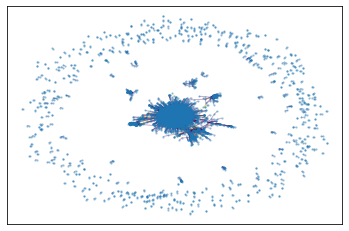

In [93]:
nx.draw_networkx(G_train, edge_color=[G_train.edges[i]['isFraud'] for i in G_train.edges()], node_size=2, with_labels=False,alpha=0.3)

In [80]:
import dgl

dgl.from_networkx(G_train)

DGL backend not selected or invalid.  Assuming PyTorch for now.
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
Using backend: pytorch


Graph(num_nodes=16496, num_edges=74568,
      ndata_schemes={}
      edata_schemes={})

In [ ]:
import dgl.function as fn